In [ ]:
##    Description    Similarity Tool for comparing two datasets 
##                   and generating a SDFile with similar compounds 
##                   
##    Authors:       Kevin Pinto Gil (kevin.pinto@upf.edu)
##                   Manuel Pastor (manuel.pastor@upf.edu)
##
##    Copyright 2015 Manuel Pastor
##
##    This file is part of PhiTools
##
##    PhiTools is free software: you can redistribute it and/or modify
##    it under the terms of the GNU General Public License as published by
##    the Free Software Foundation version 3.
##
##    PhiTools is distributed in the hope that it will be useful,
##    but WITHOUT ANY WARRANTY; without even the implied warranty of
##    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
##    GNU General Public License for more details.
##
##    You should have received a copy of the GNU General Public License
##    along with PhiTools.  If not, see <http://www.gnu.org/licenses/>

# Libraries to import to run similarity analysis

In [1]:
import urllib
import os
import sys
import getopt
import numpy as np
from cmath import *

import six

import warnings

import re
import random
 
from ipywidgets import HTML

import pandas as pd


from rdkit import Chem
from rdkit.Chem import Draw, PandasTools, AllChem
with warnings.catch_warnings():
     warnings.simplefilter("ignore")
from rdkit import DataStructs
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = (450, 200)
PandasTools.RenderImagesInAllDataFrames()

import xlrd #To read excel files

### JoseCarlos library to have interactive plots

In [2]:
from pylab import *
import matplotlib.pyplot as plt
# from utils import *

import seaborn
seaborn.set_style('whitegrid')
from matplotlib.pyplot import rcParams
rcParams["figure.figsize"]= 15 ,10

from bokeh.plotting import figure, output_notebook, show #output_file
from bokeh.models import ColumnDataSource, HoverTool, CrosshairTool, WheelZoomTool, ResetTool, PanTool
from bokeh.charts import Scatter
from PIL import Image
output_notebook()

Loading BokehJS ...

# Protocol to be followed before similarity analysis
    - Standardize field names in model molecules to be distinguised with Database field names ( e.g. name for name-model) 
    - Standardize molecules to eliminate contra ions, duplicates, molecules containing metal ions.... 
    - Double check manually if the molecules excluded are well excluded or they need to be included. 
    - Obtain 2D or 3D coordinates 
    - Protonate structures at the same pH (e.g. 7.4 pH) to be comparable
    - Calculate final smile, inchi and inchikey

# Similarity analysis using morgan finger prints
    - Define the following parameters:
    
        md = 'model.sdf' ## model structures to be compared with database
        idName = 'molID' ## field name in model which contains molecule id (e.g. mol00001 ... mol00040)
        db =  'database.sdf' ## molecules from database
        cutoff = float number ### fingerprint cutoff from 0 to 1, used to filter molecules
        outSim =  'output.sdf' ## output SDFile
    
    - Run this function:
    
        simStruct = getSimilarity(md,db,cutoff,outSim)

In [3]:
def getSimilarity(md,db,cutoff,outSim, idName):

    suppl=Chem.SDMolSupplier(md)
   
    mF_model = [] ## will contain model morgan fingerprints 
    id_model = [] ## molID of the model created by me ( e.g. mol00001)

    mdictnames = {}
    mdictvalues = {}
    
    for m in suppl:
        try:
            mf = AllChem.GetMorganFingerprintAsBitVect(m,2,nBits=1024)
            mF_model.append(mf)
            id_model.append(m.GetProp(idName))      
            
            mnames = [] # model names
            mnewnames = [] # model names  plus _CS1 to be diferentiated with database ones
            mvalues = [] # model values
            for i in m.GetPropNames():
                mnames.append(i)
                mnewnames.append('CS1_'+i) ### modify 'CS1_' for the name that you want to 
            for i in mnames:   
                mvalues.append(m.GetProp(i))
            mdictnames[m.GetProp(idName)] = mnewnames    
            mdictvalues[m.GetProp(idName)] = mvalues  
        except:
            return ('error_fingerprinting')
   
    suppl2=Chem.SDMolSupplier(db)
    counter = 0
    simStruct = []
    
    fo= open (outSim,'w')
    
    for m in suppl2:       
#         if m is None: continue
        max_similarity = 0
        max_similarity_id = ''

        try:
            mf = AllChem.GetMorganFingerprintAsBitVect(m,2,nBits=1024)
            for j in xrange(len(mF_model)):
                sim = DataStructs.FingerprintSimilarity(mF_model[j],mf)
                if sim>max_similarity:
                    max_similarity = sim
                    max_similarity_id = id_model[j]
        except:
            max_similarity = 0
            max_similarity_id= ''

        if max_similarity > cutoff and max_similarity < 1:
            simStruct.append(m)
            parent = Chem.MolToMolBlock(m)
            fo.write(parent)
            pnames = []
            for i in m.GetPropNames():
                pnames.append(i)

            pvalues = []

            for i in pnames:
                pvalues.append(m.GetProp(i))
                        
            for pn,pv in zip(pnames,pvalues):        
                fo.write('>  <'+str(pn)+'>\n'+str(pv)+'\n\n')

            for sn, sv in zip(mdictnames[max_similarity_id], mdictvalues[max_similarity_id]):
                fo.write('>  <'+str(sn)+'>\n'+str(sv)+'\n\n')
            fo.write('>  <similarity>\n'+str(max_similarity)+'\n\n')
            fo.write('$$$$\n')
            
            counter =counter+1

        else:
            pass

    print 'total molecules found = ', counter
    fo.close()
    return (simStruct)

### Running Similarity analysis
    Here we start defining model and database SD files 
    running my similarity function 
    creating and SD file with similar compounds

In [5]:
db =  '/media/sf_users/eutoxrisk/biosimilarity_task/5-CASE1-EU-ToxRisk/7-Tox21/6-moka3D/tox21-3D-moka.sdf' ## database
md = '/media/sf_users/eutoxrisk/biosimilarity_task/5-CASE1-EU-ToxRisk/4-moka3D/steatosis-3D-moka-plus-activity.sdf' ## model
cutoff = 0.6 ### cutoff similarity distance by tanimoto Morgan fingerprints
outSim = 'similars-Kevin.sdf' ### output name similars
idName = 'molID'
simStruct = getSimilarity(md,db,cutoff,outSim, idName)

total molecules found =  63


,ABUNDANCE,CS1_ABUNDANCE,CS1_AMW,CS1_AlogP,CS1_CAS,CS1_HBA,CS1_HBD,CS1_InChI,CS1_InChIkey,CS1_Lipinski_violations,CS1_NETCHARGE,CS1_PSA,CS1_QED_weighted,CS1_RO3_pass,CS1_SMILES,CS1_UniChem,CS1_UniChem_wide,CS1_activity,CS1_aromatic_rings,CS1_heavy_atoms,CS1_molID,CS1_name,CS1_parent_AMW,CS1_parent_InChI,CS1_parent_InChIkey,CS1_parent_SMILES,CS1_rotatable_bonds,ID,NETCHARGE,ToxCast_chid,Tox_Struct,inchi,parent_inchi,parent_inchikey,parent_smiles,similarity,smiles
0,99.55% at pH 7.4,99.85% at pH 7.4,150.221,2.6897,98-54-4,1,1,"InChI=1S/C10H14O/c1-10(2,3)8-4-6-9(11)7-5-8/h4-7,11H,1-3H3",QHPQWRBYOIRBIT-UHFFFAOYSA-N,0,-0.001454,20.23,0.5999314436,1,CC(C)(C)c1ccc(O)cc1,21,405,na,1,11,mol000039,4-tert-Butylphenol,150.221,"InChI=1S/C10H14O/c1-10(2,3)8-4-6-9(11)7-5-8/h4-7,11H,1-3H3",QHPQWRBYOIRBIT-UHFFFAOYSA-N,CC(C)(C)c1ccc(O)cc1,0,,-0.004516,20182,,"InChI=1S/C15H16O2/c1-15(2,11-3-7-13(16)8-4-11)12-5-9-14(17)10-6-12/h3-10,16-17H,1-2H3","InChI=1S/C15H16O2/c1-15(2,11-3-7-13(16)8-4-11)12-5-9-14(17)10-6-12/h3-10,16-17H,1-2H3",IISBACLAFKSPIT-UHFFFAOYSA-N,CC(C)(c1ccc(O)cc1)c1ccc(O)cc1,0.722222222222,CC(C)(C1=CC=C(O)C=C1)C1=CC=C(O)C=C1
1,99.98% at pH 7.4,100% at pH 7.4,234.383,4.5496,4130-42-1,1,1,"InChI=1S/C16H26O/c1-8-11-9-12(15(2,3)4)14(17)13(10-11)16(5,6)7/h9-10,17H,8H2,1-7H3",BVUXDWXKPROUDO-UHFFFAOYSA-N,0,-0.00004912,20.23,0.7222938266,0,CCc1cc(C(C)(C)C)c(O)c(C(C)(C)C)c1,15,61,na,1,17,mol000026,"2,6-Di-tert-butyl-4-ethylphenol",234.383,"InChI=1S/C16H26O/c1-8-11-9-12(15(2,3)4)14(17)13(10-11)16(5,6)7/h9-10,17H,8H2,1-7H3",BVUXDWXKPROUDO-UHFFFAOYSA-N,CCc1cc(C(C)(C)C)c(O)c(C(C)(C)C)c1,1,,-0.0002144,20211,,"InChI=1S/C15H24O2/c1-14(2,3)11-7-10(9-16)8-12(13(11)17)15(4,5)6/h7-8,16-17H,9H2,1-6H3","InChI=1S/C15H24O2/c1-14(2,3)11-7-10(9-16)8-12(13(11)17)15(4,5)6/h7-8,16-17H,9H2,1-6H3",HNURKXXMYARGAY-UHFFFAOYSA-N,CC(C)(C)c1cc(CO)cc(C(C)(C)C)c1O,0.68,CC(C)(C)C1=CC(CO)=CC(=C1O)C(C)(C)C
2,99.97% at pH 7.4,99.83% at pH 7.4,166.22,2.3953,1948-33-0,2,2,"InChI=1S/C10H14O2/c1-10(2,3)8-6-7(11)4-5-9(8)12/h4-6,11-12H,1-3H3",BGNXCDMCOKJUMV-UHFFFAOYSA-N,0,-0.001728,40.46,0.5810543644,1,CC(C)(C)c1cc(O)ccc1O,21,87,na,1,12,mol000020,tert-Butylhydroquinone,166.22,"InChI=1S/C10H14O2/c1-10(2,3)8-6-7(11)4-5-9(8)12/h4-6,11-12H,1-3H3",BGNXCDMCOKJUMV-UHFFFAOYSA-N,CC(C)(C)c1cc(O)ccc1O,0,,-0.0002953,20212,,"InChI=1S/C11H16O/c1-8-5-6-10(12)9(7-8)11(2,3)4/h5-7,12H,1-4H3","InChI=1S/C11H16O/c1-8-5-6-10(12)9(7-8)11(2,3)4/h5-7,12H,1-4H3",IKEHOXWJQXIQAG-UHFFFAOYSA-N,Cc1ccc(O)c(C(C)(C)C)c1,0.64,CC1=CC(=C(O)C=C1)C(C)(C)C
3,99.44% at pH 7.4,99.92% at pH 7.4,122.167,2.00904,105-67-9,1,1,"InChI=1S/C8H10O/c1-6-3-4-8(9)7(2)5-6/h3-5,9H,1-2H3",KUFFULVDNCHOFZ-UHFFFAOYSA-N,0,-0.0007595,20.23,0.5605086279,1,Cc1ccc(O)c(C)c1,18,180,na,1,9,mol000003,"2,4-Dimethylphenol",122.167,"InChI=1S/C8H10O/c1-6-3-4-8(9)7(2)5-6/h3-5,9H,1-2H3",KUFFULVDNCHOFZ-UHFFFAOYSA-N,Cc1ccc(O)c(C)c1,0,,-0.005606,20861,,"InChI=1S/C7H8O2/c1-5-2-3-6(8)7(9)4-5/h2-4,8-9H,1H3","InChI=1S/C7H8O2/c1-5-2-3-6(8)7(9)4-5/h2-4,8-9H,1H3",ZBCATMYQYDCTIZ-UHFFFAOYSA-N,Cc1ccc(O)c(O)c1,0.65,CC1=CC(O)=C(O)C=C1
4,99.87% at pH 7.4,99.99% at pH 7.4,220.356,4.29562,128-37-0,1,1,"InChI=1S/C15H24O/c1-10-8-11(14(2,3)4)13(16)12(9-10)15(5,6)7/h8-9,16H,1-7H3",NLZUEZXRPGMBCV-UHFFFAOYSA-N,0,-0.00005749,20.23,0.6625535227,0,Cc1cc(C(C)(C)C)c(O)c(C(C)(C)C)c1,24,501,na,1,16,mol000012,Butylated hydroxytoluene,220.356,"InChI=1S/C15H24O/c1-10-8-11(14(2,3)4)13(16)12(9-10)15(5,6)7/h8-9,16H,1-7H3",NLZUEZXRPGMBCV-UHFFFAOYSA-N,Cc1cc(C(C)(C)C)c(O)c(C(C)(C)C)c1,0,,-0.001339,20870,,"InChI=1S/C23H32O2/c1-14-9-16(20(24)18(11-14)22(3,4)5)13-17-10-15(2)12-19(21(17)25)23(6,7)8/h9-12,24-25H,13H2,1-8H3","InChI=1S/C23H32O2/c1-14-9-16(20(24)18(11-14)22(3,4)5)13-17-10-15(2)12-19(21(17)25)23(6,7)8/h9-12,24-25H,13H2,1-8H3",KGRVJHAUYBGFFP-UHFFFAOYSA-N,Cc1cc(Cc2cc(C)cc(C(C)(C)C)c2O)c(O)c(C(C)(C)C)c1,0.68,CC1=CC(CC2=CC(C)=CC(=C2O)C(C)(C)C)=C(O)C(=C1)C(C)(C)C
5,99.93% at pH 7.4,99.92% at pH 7.4,122.167,2.00904,105-67-9,1,1,"InChI=1S/C8H10O/c1-6-3-4-8(9)7(2)5-6/h3-5,9H,1-2H3",KUFFULVDNC
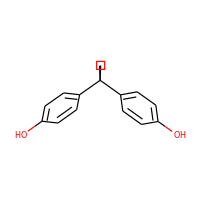
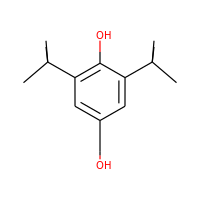
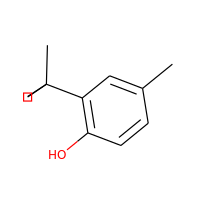
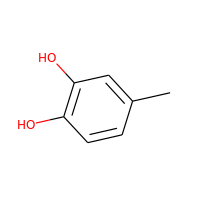
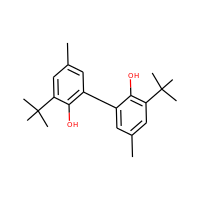
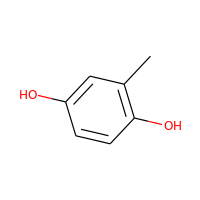
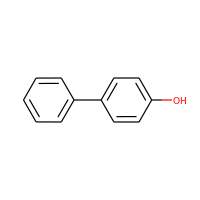
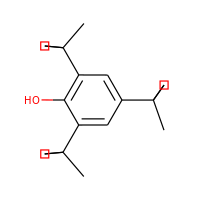
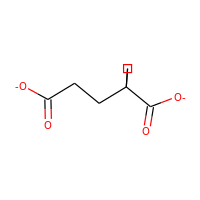
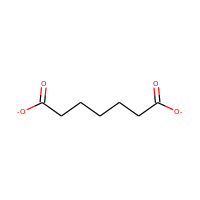
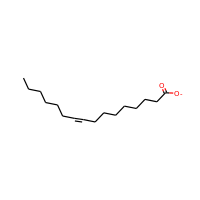
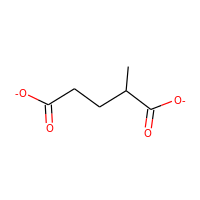
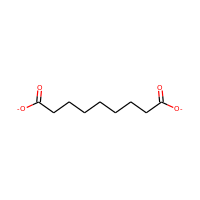
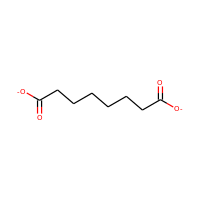
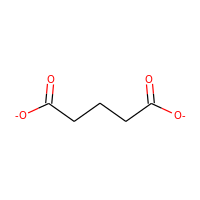
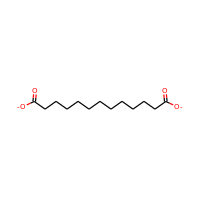
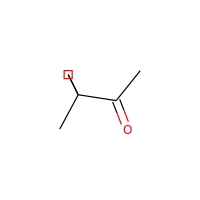
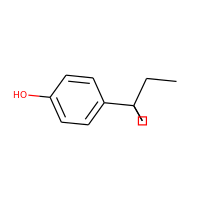
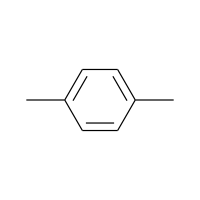
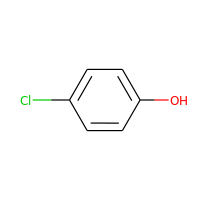
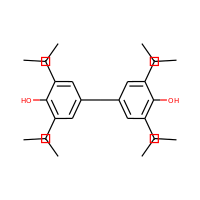
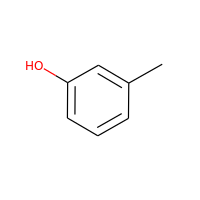
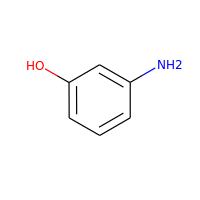
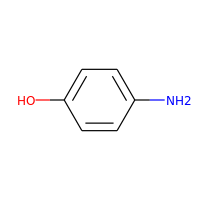
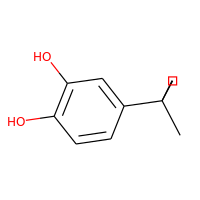
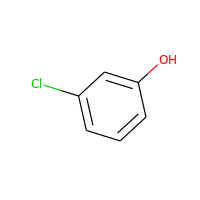
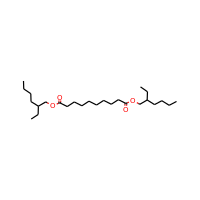
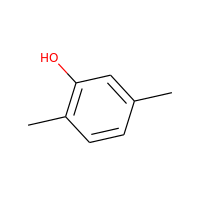
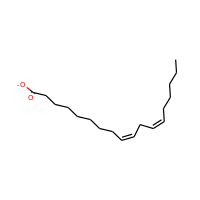
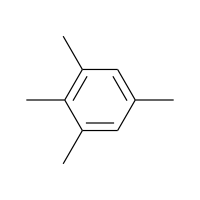
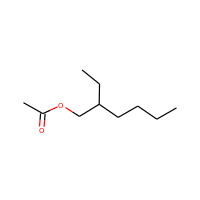
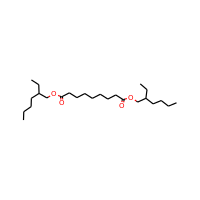
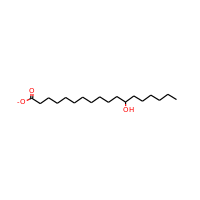
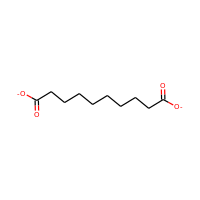
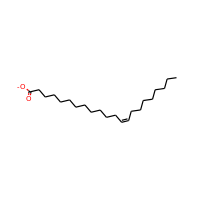
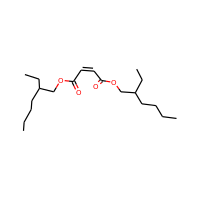
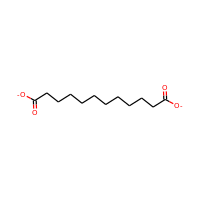
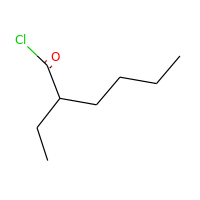
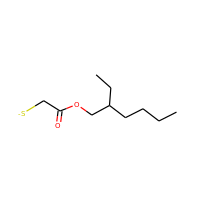
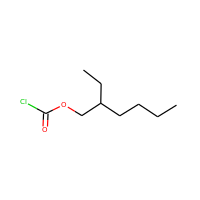
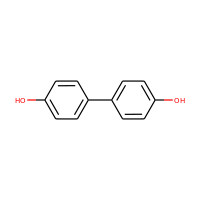
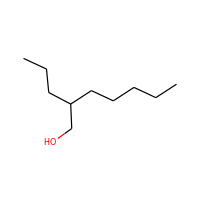
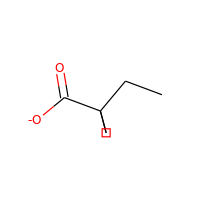
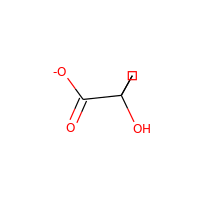
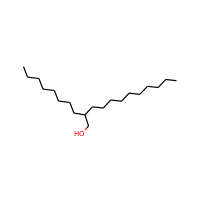
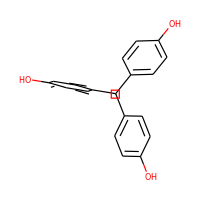
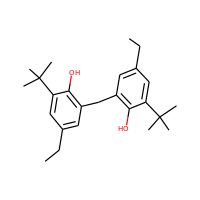
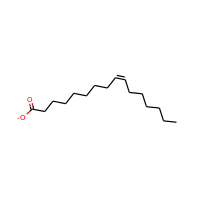
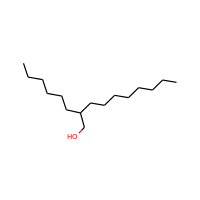
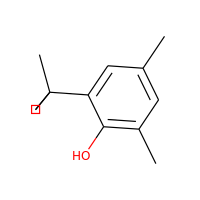
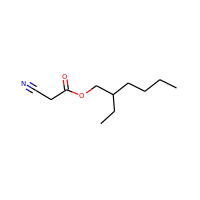
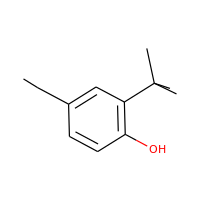
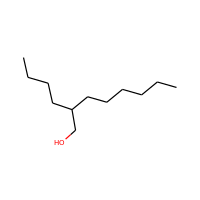
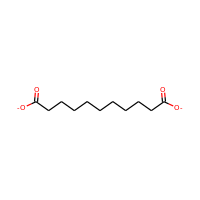
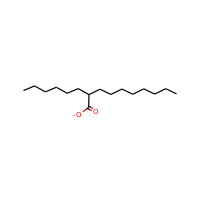
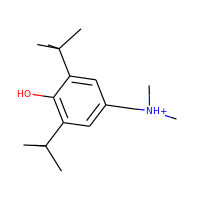
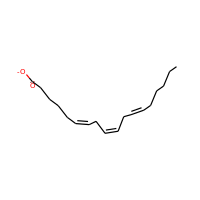
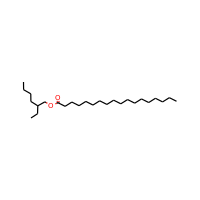
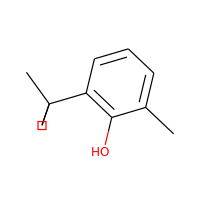
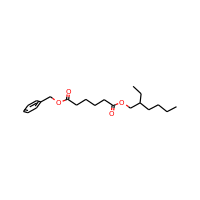
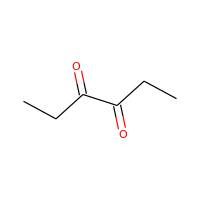
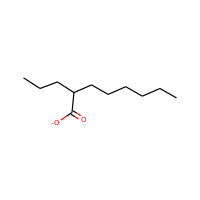
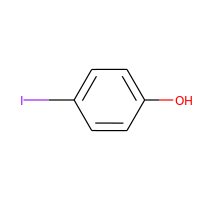

In [7]:
similars = PandasTools.LoadSDF('similars-Kevin.sdf',smilesName='parent_smiles', molColName='Tox_Struct', 
                              includeFingerprints=True)
# similars.columns ### to show the column names
similars

In [8]:
# Here we sort by molID asceding and afterthat, by similarity descending
sim_sort1 = similars.sort(['CS1_molID', 'similarity'], ascending=[True, False])
PandasTools.AddMoleculeColumnToFrame(sim_sort1,'parent_smiles', 'Tox21_molecule',includeFingerprints=True)
sim_sort2 = sim_sort1.ix[:,['Tox21_molecule','CS1_molID', 'ToxCast_chid', 'CS1_parent_SMILES','CS1_name', 'similarity']] 

/opt/anaconda2/envs/phi/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


In [9]:
PandasTools.AddMoleculeColumnToFrame(sim_sort2,'CS1_parent_SMILES', 'CS1_molecule',includeFingerprints=True)

In [10]:
similars_tox21_vs_CS1 = sim_sort2.ix[:,['Tox21_molecule','CS1_molecule','ToxCast_chid','CS1_molID', 'CS1_name', 'similarity']] 

,Tox21_molecule,CS1_molecule,ToxCast_chid,CS1_molID,CS1_name,similarity
26,,,25055,mol000001,Di(2-ethylhexyl) adipate,0.964285714286
31,,,26697,mol000001,Di(2-ethylhexyl) adipate,0.964285714286
57,,,47178,mol000001,Di(2-ethylhexyl) adipate,0.931034482759
38,,,27656,mol000001,Di(2-ethylhexyl) adipate,0.71875
59,,,47528,mol000001,Di(2-ethylhexyl) adipate,0.692307692308
30,,,26694,mol000001,Di(2-ethylhexyl) adipate,0.677419354839
50,,,44378,mol000001,Di(2-ethylhexyl) adipate,0.657142857143
35,,,27094,mol000001,Di(2-ethylhexyl) adipate,0.65625
39,,,27832,mol000001,Di(2-ethylhexyl) adipate,0.65625
52,,,44818,mol000002,2-Ethyl-1-hexanol,0.681818181818

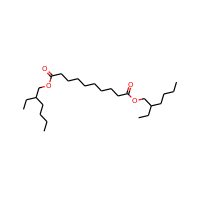
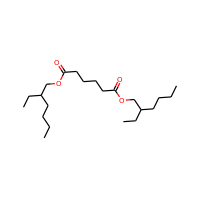
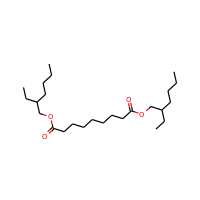
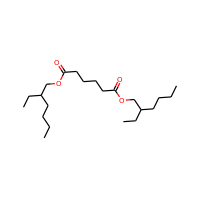
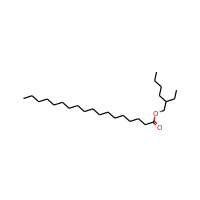
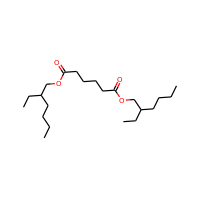
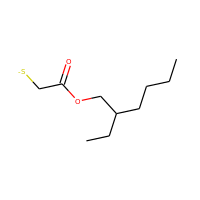
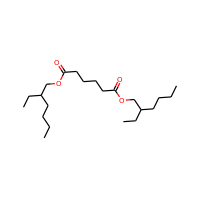
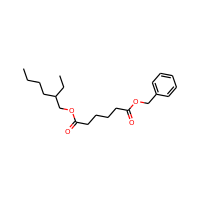
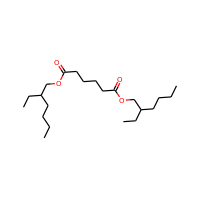
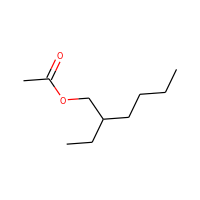
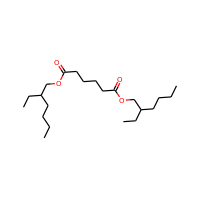
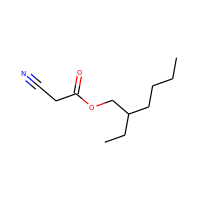
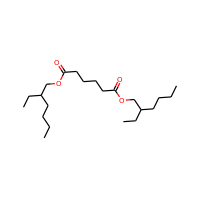
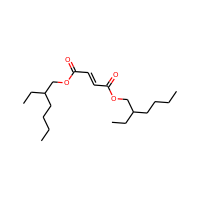
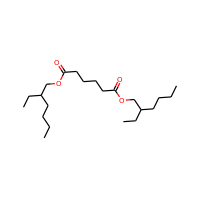
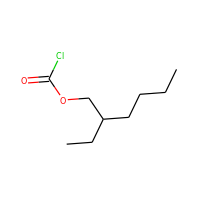
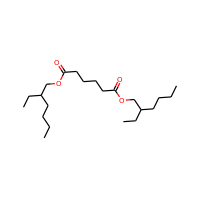
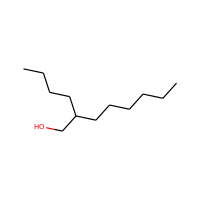
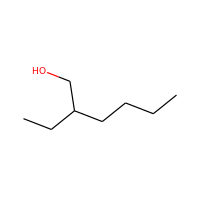
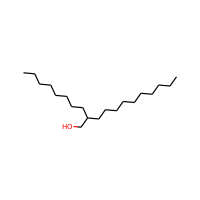
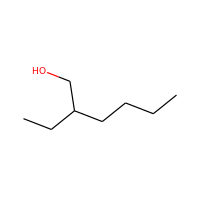
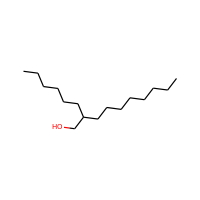
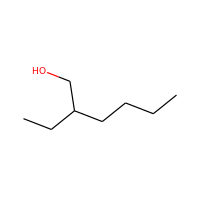
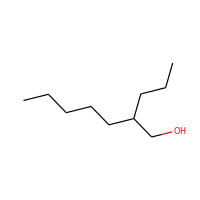
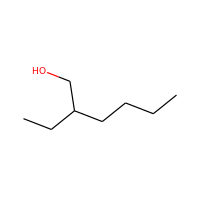
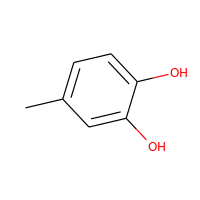
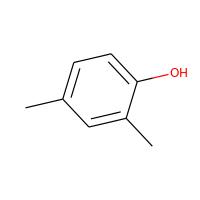
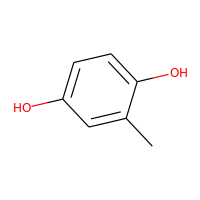
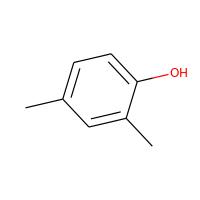
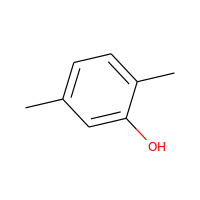
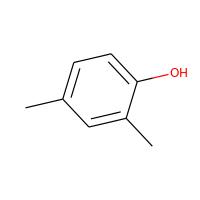
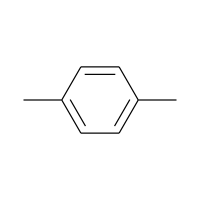
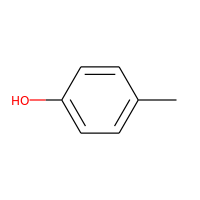
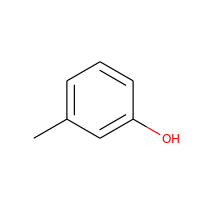
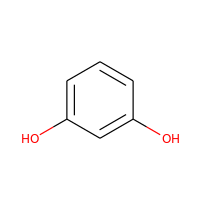
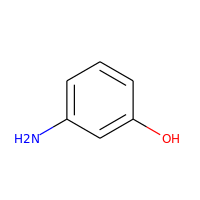
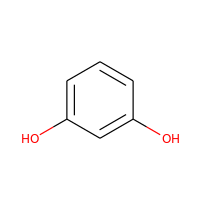
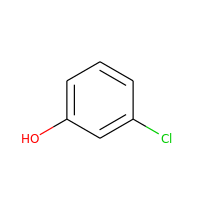
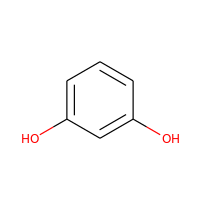
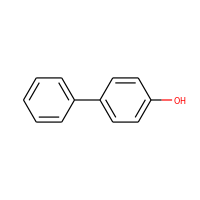
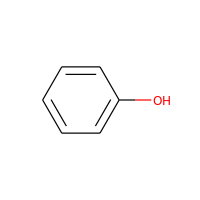
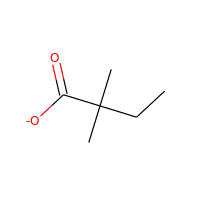
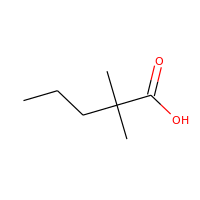
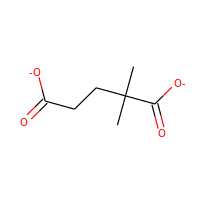
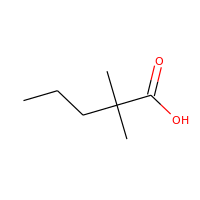
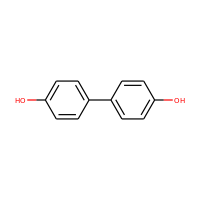
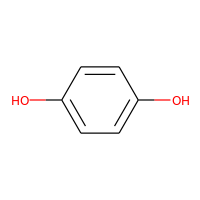
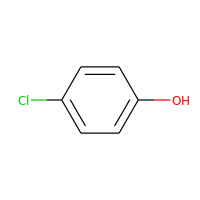
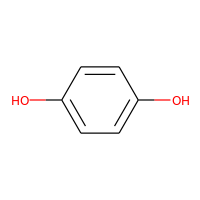
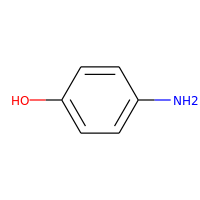
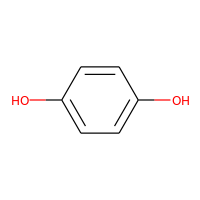
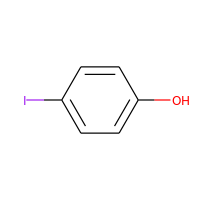
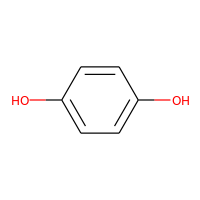
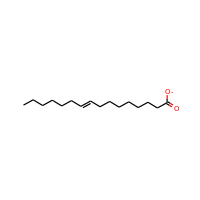
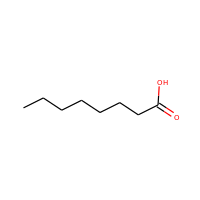
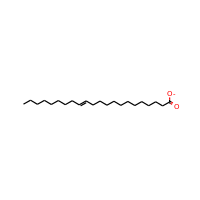
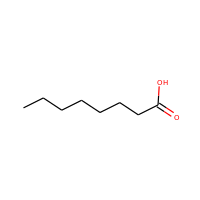
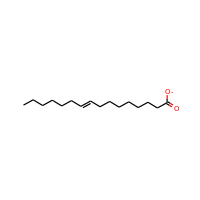
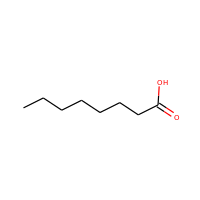
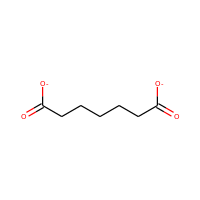
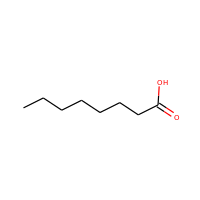
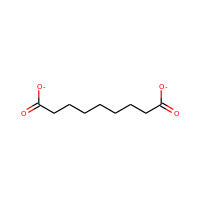
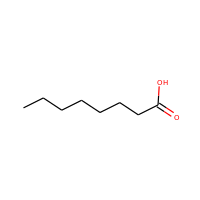
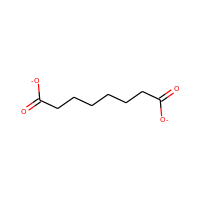
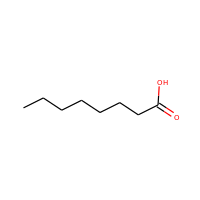
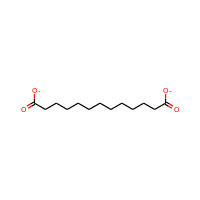
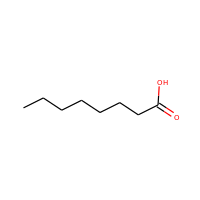
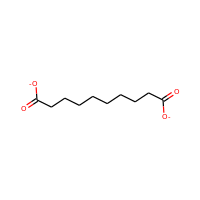
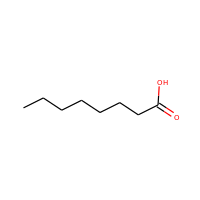
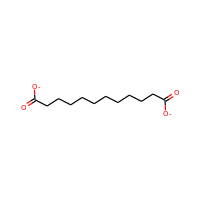
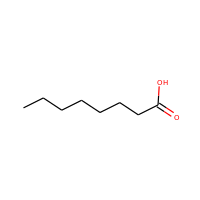
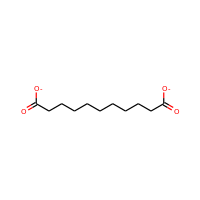
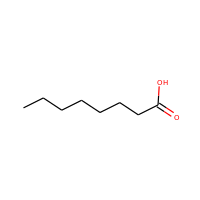
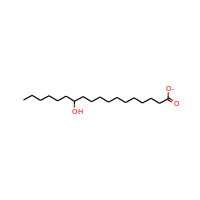
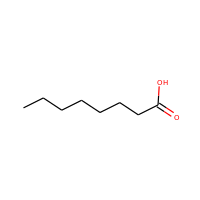
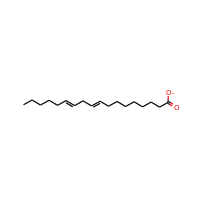
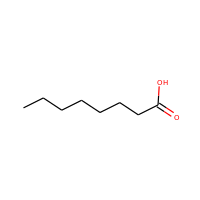
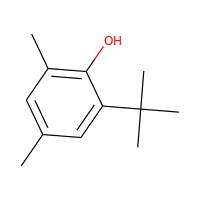
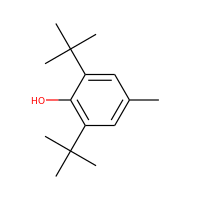
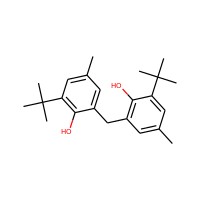
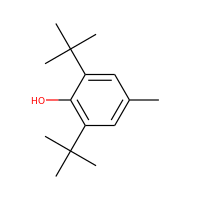
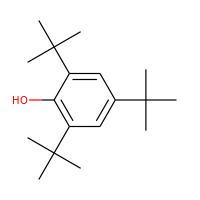
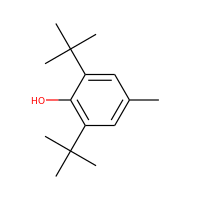
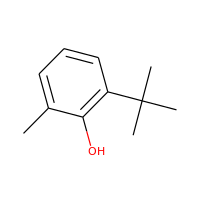
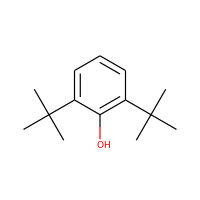
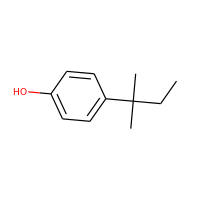
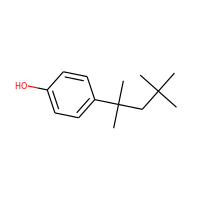
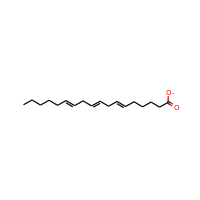
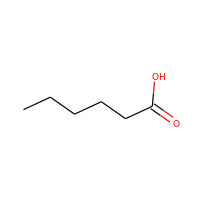
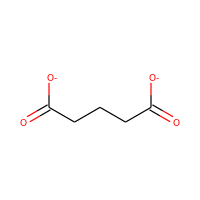
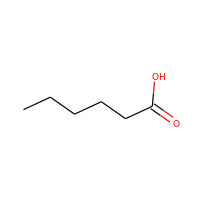
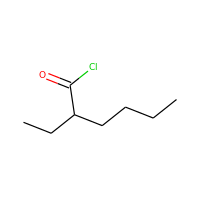
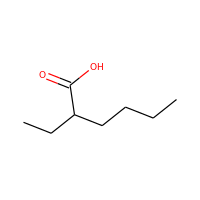
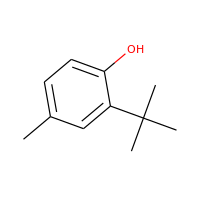
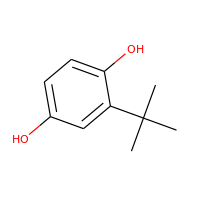
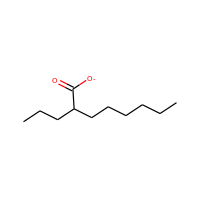
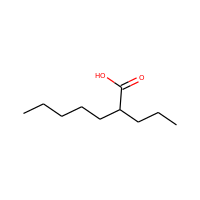
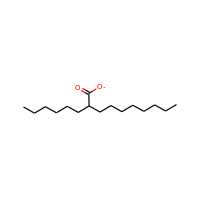
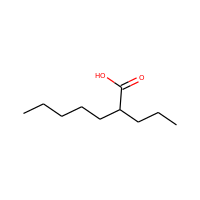
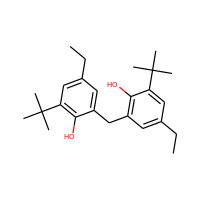
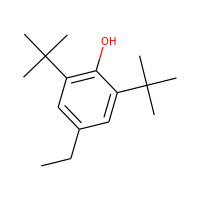
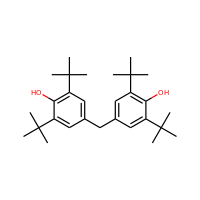
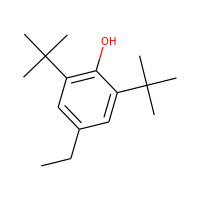
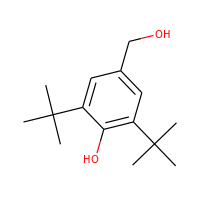
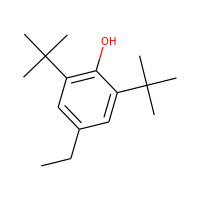
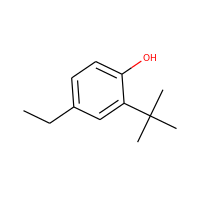
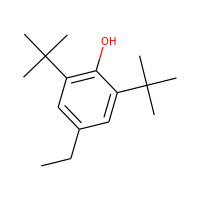
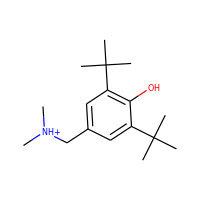
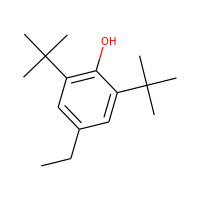
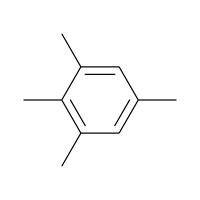
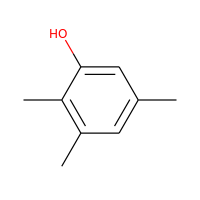
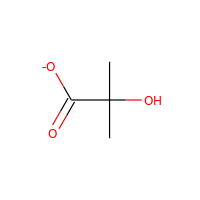
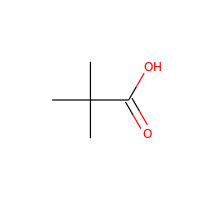
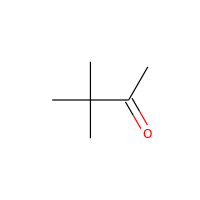
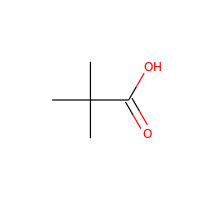
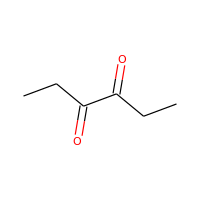
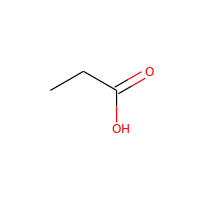
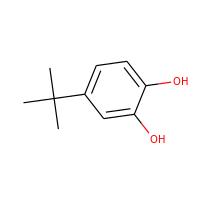
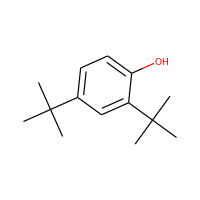
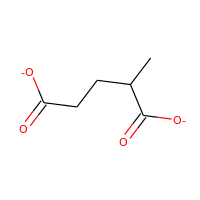
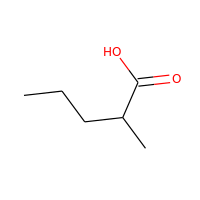
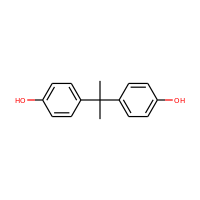
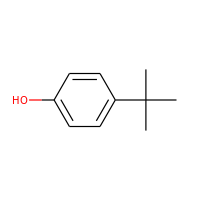
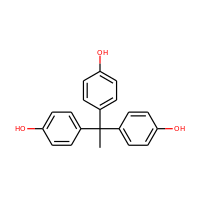
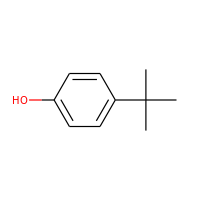

In [11]:
similars_tox21_vs_CS1